In [17]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision

In [18]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels):
        super(PatchGANDiscriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size = 4, stride = 2, padding = 1, padding_mode = 'reflect'),
            nn.LeakyReLU(0.2),
            self.con_block(64, 128, 4, 2, 1),
            self.con_block(128, 256, 4, 2, 1),
            self.con_block(256, 512, 4, 2, 2),
#             self.con_block(512, 512, 4, 1, 1),
            nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 1, padding_mode = 'reflect')
        )
        
    def con_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode = 'reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, img):
        return self.disc(img)

In [19]:
def test():
    imgs_fake = torch.randn((1, 3, 256, 256))
    model = PatchGANDiscriminator(3)
    preds = model(imgs_fake)
    print(preds.shape)

In [20]:
test()

torch.Size([1, 1, 16, 16])


In [21]:
class ResNetBlocks(nn.Module):
    def __init__(self, in_channels):
        super(ResNetBlocks, self).__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size = 3, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(256),
            nn.ReLU(),   
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(256),
        )
        
    def forward(self, x):
        return x + self.resnet(x)

In [22]:
class Generator(nn.Module):
    def __init__(self, in_channels):
        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size = 7, padding = 3, padding_mode = 'reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU(),  
            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(128),
            nn.ReLU(), 
            nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(256),
            nn.ReLU(),           
        )
        
        self.block2 = nn.Sequential(
            *[ResNetBlocks(256) for i in range(9)]
        )
        
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1,output_padding = 1 ),
            nn.InstanceNorm2d(128),
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1,output_padding = 1 ),
            nn.InstanceNorm2d(64),
            nn.ReLU(), 
            nn.Conv2d(64, 3, kernel_size = 7, stride =1, padding = 3, padding_mode = 'reflect'),
            nn.Tanh(), 
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.block3(x)

In [23]:
def test():
    imgs_fake = torch.randn((1, 3, 256, 256))
    model = Generator(3)
    preds = model(imgs_fake)
    print(preds.shape)

In [24]:
test()

torch.Size([1, 3, 256, 256])


In [25]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02),
        torch.nn.init.normal_(m.bias, 0)

In [26]:
device = 'cpu'
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

genA_B = Generator(3).to(device)
genB_A = Generator(3).to(device)
discA_B = PatchGANDiscriminator(3).to(device)
discB_A = PatchGANDiscriminator(3).to(device)

gen_opt = torch.optim.Adam(list(genA_B.parameters()) + list(genB_A.parameters()), lr=lr, betas=(beta_1, beta_2))
disc_optA_B = torch.optim.Adam(discA_B.parameters(), lr = lr, betas = (beta_1, beta_2))
disc_optB_A = torch.optim.Adam(discB_A.parameters(), lr = lr, betas = (beta_1, beta_2))

genA_B = genA_B.apply(weights_init)
genB_A = genB_A.apply(weights_init)
discA_B = discA_B.apply(weights_init)
discB_A = discB_A.apply(weights_init)

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_id = torch.nn.L1Loss()

In [27]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import glob

class Horse2ZebraDataset(Dataset):
    def __init__(self, root_dir_zebra, root_dir_horse, transform = None):
        self.root_dir_zebra = root_dir_zebra
        self.root_dir_horse = root_dir_horse
        self.transform = transform
        self.zebra_files = os.listdir(self.root_dir_zebra)
        self.horse_files = os.listdir(self.root_dir_horse)
        
    def __len__(self):
        return max(len(self.zebra_files), len(self.horse_files))
    
    def __getitem__(self, index):
        zebra_img = self.zebra_files[index % len(self.zebra_files)]
        horse_img = self.horse_files[index % len(self.horse_files)]
        zebra_img_path = os.path.join(self.root_dir_zebra, zebra_img)
        horse_img_path = os.path.join(self.root_dir_horse, horse_img)
        img_zebra = Image.open(zebra_img_path).convert('RGB')
        img_horse = Image.open(horse_img_path).convert('RGB')

        if self.transform :
            img_zebra = self.transform(img_zebra)
            img_horse = self.transform(img_horse)

        return img_zebra, img_horse

In [28]:
n_epochs = 20
img_channels = 3
steps = 100
batch_size = 1
img_shape = 256

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = Horse2ZebraDataset("horse2zebra/trainB/", "horse2zebra/trainA/", transform=transform)
dataloader = DataLoader(dataset, batch_size= 1)

In [29]:
for z, h in dataloader:
        print(z.shape)
        save_image(z, "z.png")
        save_image(h, "h.png")
        break;

torch.Size([1, 3, 256, 256])


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    img = img.detach().cpu()
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Epochs: 0 Step: 100 Generator loss: 12.538898067474365, discriminator loss: 0.2844875590503216


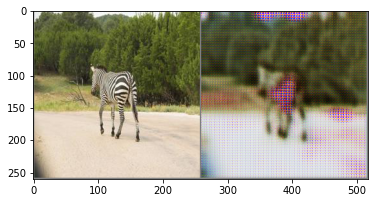

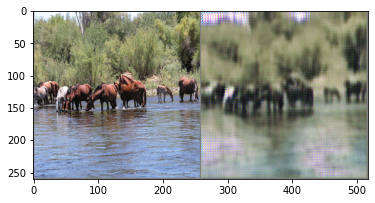

Epochs: 0 Step: 200 Generator loss: 12.181388177871703, discriminator loss: 0.29667855717241765


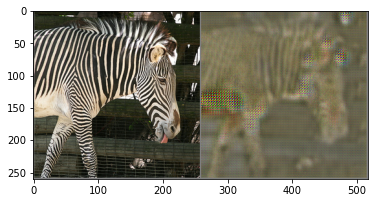

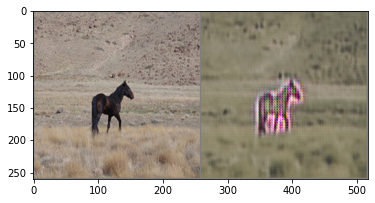

Epochs: 0 Step: 300 Generator loss: 12.270013518333435, discriminator loss: 0.2833906614780426


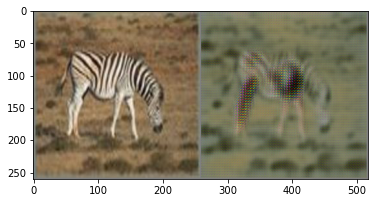

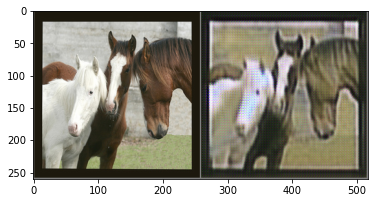

Epochs: 0 Step: 400 Generator loss: 12.28680202484131, discriminator loss: 0.2924210169911385


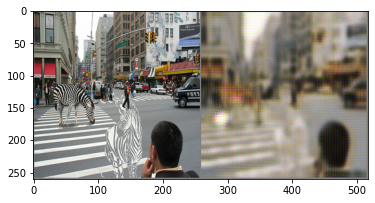

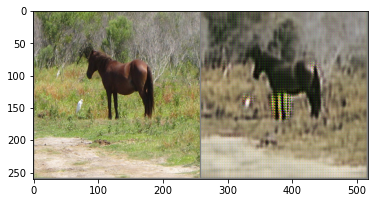

Epochs: 0 Step: 500 Generator loss: 12.232356796264648, discriminator loss: 0.2778152149915695


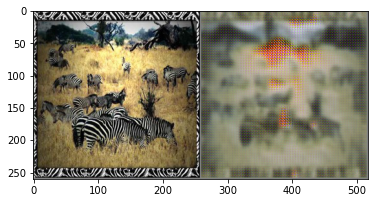

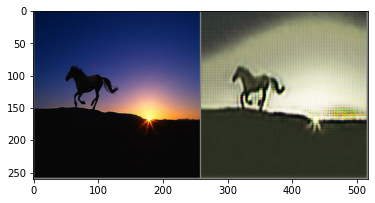

Epochs: 0 Step: 600 Generator loss: 12.171006526947021, discriminator loss: 0.26653397977352145


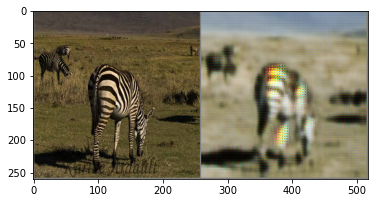

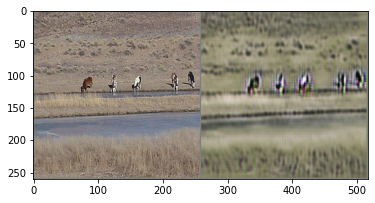

Epochs: 0 Step: 700 Generator loss: 11.52462453365326, discriminator loss: 0.282598869651556


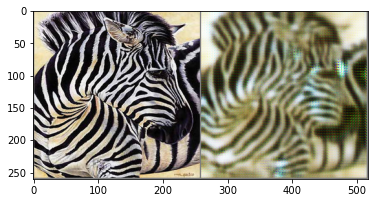

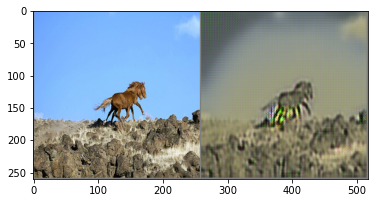

Epochs: 0 Step: 800 Generator loss: 11.629704542160034, discriminator loss: 0.2817929199337959


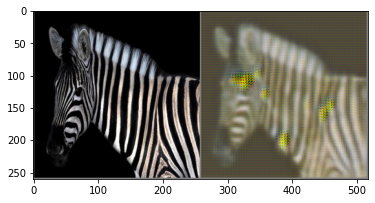

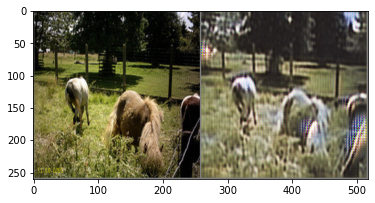

KeyboardInterrupt: 

In [33]:
current_step = 0
gen_losses = 0
disc_losses = 0
os.makedirs("cyclegan", exist_ok=True)

for epoch in range(n_epochs):
    for z, h in dataloader :
        z = z.to(device)
        h = h.to(device)
        
        disc_optA_B.zero_grad()
        fake_horse = genA_B(z)
        disc_preds_fake1 = discA_B(fake_horse.detach())
        disc_fake_loss1 = criterion_GAN(disc_preds_fake1, torch.zeros_like(disc_preds_fake1))
        disc_preds_real1 = discA_B(h)
        disc_real_loss1 = criterion_GAN(disc_preds_real1, torch.ones_like(disc_preds_real1))
        discA_B_loss = (disc_fake_loss1 + disc_real_loss1) / 2
        discA_B_loss.backward(retain_graph = True)
        disc_optA_B.step()
        
        disc_optB_A.zero_grad()
        fake_zebra = genB_A(h)
        disc_preds_fake2 = discB_A(fake_zebra.detach())
        disc_fake_loss2 = criterion_GAN(disc_preds_fake2, torch.zeros_like(disc_preds_fake2))
        disc_preds_real2 = discB_A(z)
        disc_real_loss2 = criterion_GAN(disc_preds_real2, torch.ones_like(disc_preds_real2))
        discB_A_loss = (disc_fake_loss2 + disc_real_loss2) / 2
        discB_A_loss.backward(retain_graph = True)
        disc_optB_A.step()
        
        
        gen_opt.zero_grad()
        fake_horse2 = genA_B(z)
        disc_preds_fake1 = discA_B(fake_horse2)
        disc_fake_loss1 = criterion_GAN(disc_preds_fake1, torch.ones_like(disc_preds_fake1))
        
        fake_zebra2 = genB_A(h)
        disc_preds_fake2 = discB_A(fake_zebra2)
        disc_fake_loss2 = criterion_GAN(disc_preds_fake2, torch.ones_like(disc_preds_fake2))
        gen_adv_loss = disc_fake_loss1 + disc_fake_loss2
        
        real_horse_gen = genB_A(fake_horse2)
        cycle_loss1 = criterion_cycle(real_horse_gen, h)
        real_zebra_gen = genA_B(fake_zebra2)
        cycle_loss2 = criterion_cycle(real_zebra_gen, z)
        cycle_loss = cycle_loss1 + cycle_loss2
        
        horse_id = genA_B(h)
        id_loss1 = criterion_id(horse_id, h)
        zebra_id = genB_A(z)
        id_loss2 = criterion_id(zebra_id, z)
        id_loss = id_loss1 + id_loss2
        
        gen_loss = gen_adv_loss + 10*cycle_loss + 5*id_loss
        gen_loss.backward()
        gen_opt.step()
        
        disc_losses += discA_B_loss.item()
        gen_losses += gen_loss.item()
        
        if current_step % steps == 0 and current_step > 0 :
            print(f"Epochs: {epoch} Step: {current_step} Generator loss: {gen_losses / steps}, discriminator loss: {disc_losses / steps}")
            img_grid_z = torchvision.utils.make_grid(torch.cat([z[:3], fake_horse[:3]]), nrow = 3)
#             img_grid_fakez = torchvision.utils.make_grid(fake_zebra[:3], nrow = 3)
            img_grid_h = torchvision.utils.make_grid(torch.cat([h[:3], fake_zebra[:3]]), nrow = 3)
#             img_grid_fakeh = torchvision.utils.make_grid(fake_horse[:3], nrow = 3)
            matplotlib_imshow(img_grid_z, one_channel=False)
#             matplotlib_imshow(img_grid_fakez,  one_channel=False)
            matplotlib_imshow(img_grid_h,  one_channel=False)
#             matplotlib_imshow(img_grid_fakeh,  one_channel=False)
            gen_losses = 0
            disc_losses = 0
        
        current_step += 1